# 3. Classification

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import StratifiedKFold

data: pd.DataFrame = pd.read_csv('prepared_b_gs.csv', sep=';')
data

,"sum(ejection_fraction,age)","sum(platelets,age)","sum(serum_sodium,age)","diff(serum_sodium,creatinine_phosphokinase)","diff(serum_sodium,platelets)","diff(time,serum_creatinine)","prod(ejection_fraction,creatinine_phosphokinase)","prod(platelets,creatinine_phosphokinase)","prod(time,creatinine_phosphokinase)",ejection_fraction,DEATH_EVENT
0,0.754011,1.105216,0.853755,-0.253598,-0.251461,-0.866667,0.055411,0.220825,0.000000,0.117647,True
1,0.572193,0.585693,0.628458,0.074937,0.042766,-0.455991,0.011644,0.012980,0.001057,0.117647,True
2,0.299465,0.470343,0.703557,0.452627,0.233215,-0.855991,0.008131,0.019941,0.000738,0.117647,True
3,1.418895,1.177943,1.213439,0.289843,0.035495,-0.985765,0.007395,0.003900,0.000206,0.509804,True
4,0.655971,0.652757,1.158103,0.337439,0.505346,-0.378648,0.003614,0.003021,0.003935,0.019608,True
...,...,...,...,...,...,...,...,...,...,...,...
321,1.311083,1.174068,1.255938,-0.147448,0.081870,-0.338471,0.264890,0.187766,0.160626,0.470588,True
322,0.939838,0.875522,1.109904,0.168815,0.234381,-0.284634,0.142812,0.118467,0.055539,0.377280,True
323,0.748921,0.737224,0.978326,0.379655,0.241103,-0.387530,0.049772,0.047897,0.058010,0.310530,True
324,0.618408,0.845326,1.039736,0.428501,0.194410,-0.176395,0.041185,0.086429,0.008419,0.206559,True


## 3.0. Training Models

---

### Training Models

---

#### StratifiedKFold function
After loading the data, in data dataframe, we need to separate the target variable which is the DEATH_EVENT from the rest of the data, since it plays a different role in the training procedure. Through the application of the pop method, we get the class variable, and simultaneously removing it from the dataframe. So, y will keep the ndarray with the target variable for each record and X the ndarray containing the records themselves

In [2]:
target = 'DEATH_EVENT'
positive = True
negative = False
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)

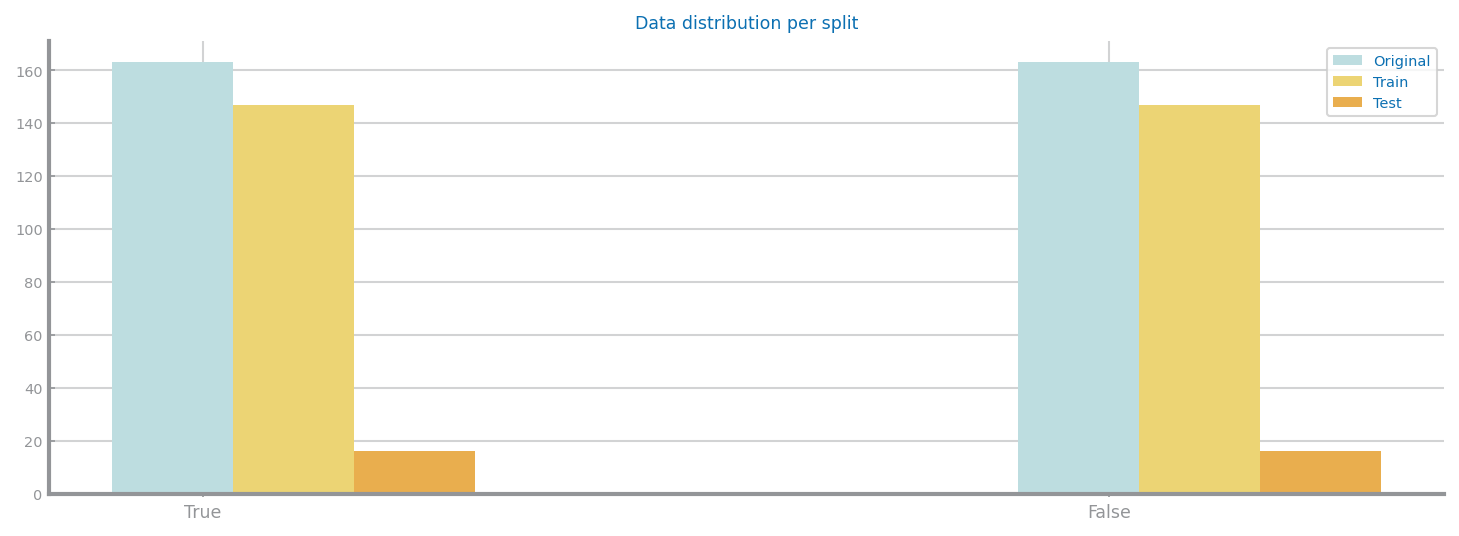

In [3]:
np.random.seed(1)
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X, y)

splits=[]

for train_index, test_index in skf.split(X, y):
    splits.append({'X_train': X[train_index], 'X_test': X[test_index],
                  'y_train': y[train_index], 'y_test': y[test_index]})

values['Train'] = [len(np.delete(y[train_index], np.argwhere(y[train_index]==negative))), len(np.delete(y[train_index], np.argwhere(y[train_index]==positive)))]
values['Test'] = [len(np.delete(y[test_index], np.argwhere(y[test_index]==negative))), len(np.delete(y[test_index], np.argwhere(y[test_index]==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per split', showXTickLabels=True)
plt.show()

We have just plotted the chart of one split because the splits have identical distribution which will make the bar charts equal.

## 3.1. Naive Bayes

---

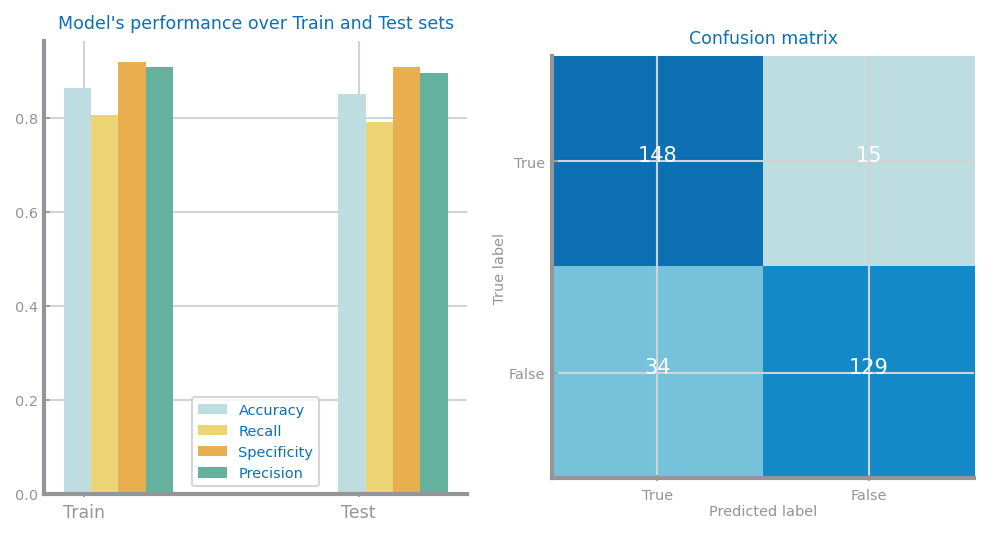

In [4]:
import sklearn.metrics as metrics
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

totalYTrn = np.array(())
totalPrd_trn = np.array(())
totalYTst = np.array(())
totalPrd_tst = np.array(())

clf = GaussianNB()
for split in splits:
    clf.fit(split['X_train'], split['y_train'])
    
    prd_trn = clf.predict(split['X_train'])
    totalYTrn = np.concatenate((totalYTrn, split['y_train']))
    totalPrd_trn = np.concatenate((totalPrd_trn, prd_trn))
    
    prd_tst = clf.predict(split['X_test'])
    totalYTst = np.concatenate((totalYTst, split['y_test']))
    totalPrd_tst = np.concatenate((totalPrd_tst, prd_tst))
    
ds.plot_evaluation_results(labels, totalYTrn, totalPrd_trn, totalYTst, totalPrd_tst, showXTickLabels=True)

Mean values:
GaussianNB: 0.849
BernoulliNB: 0.81
95% cofidence interval for accuracy:
GaussianNB: [0.816,0.883]
BernoulliNB: [0.773,0.847]
99% cofidence interval for accuracy:
GaussianNB: [0.799,0.9]
BernoulliNB: [0.754,0.866]


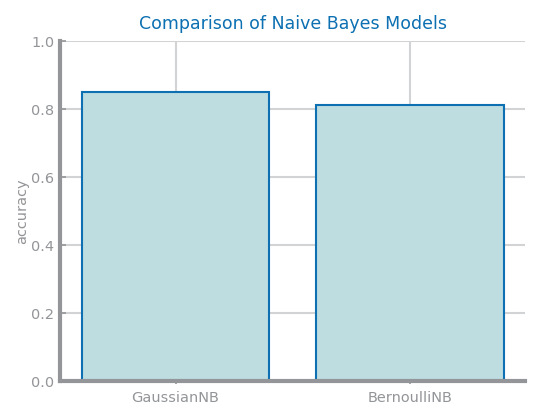

In [5]:
estimators = {'GaussianNB': GaussianNB(),
              #'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()}

xvalues = [est for est in estimators]
yvalues = [np.zeros(10) for _ in estimators]

for spli in range(len(splits)):
    split = splits[spli]
    for i in range(len(xvalues)):
        clf = xvalues[i]
        estimators[clf].fit(split['X_train'], split['y_train'])
        prdY = estimators[clf].predict(split['X_test'])
        yvalues[i][spli] = metrics.accuracy_score(split['y_test'], prdY)

estimator_names = ('GaussianNB','BernoulliNB')# 'MultinomialNB', 'BernoulliNB')
means = [np.mean(accs) for accs in yvalues]
stds = [np.std(accs) for accs in yvalues]
confidences = (0.95, 0.99)
t_st = (1.812, 2.764)

print("Mean values:")
for est in range(len(estimators)):
    print(f'{estimator_names[est]}: {round(means[est], 3)}')

for c in range(len(confidences)):
    conf = confidences[c]
    print(f'{int(conf*100)}% cofidence interval for accuracy:')
    for est in range(len(estimators)):
        minAcc = means[est] - t_st[c] * stds[est] / (10**0.5)
        maxAcc = means[est] + t_st[c] * stds[est] / (10**0.5)
        print(f'{estimator_names[est]}: [{round(minAcc, 3)},{round(maxAcc, 3)}]')


plt.figure()
ds.bar_chart(xvalues, means, title='Comparison of Naive Bayes Models', ylabel='accuracy', percentage=True)
plt.show()

### Summary

---

***Which distribution is more adequate to model our data?***

For most of the splits, the Gaussian distribution models better our data.

***Is the accuracy achieved good enough?***

The accuracy is better than the one of the classifier that considers every record is negative. However, this doesn't mean the classifier is good enough. We still consider it is not very good.

***What is the largest kind of errors?***

False negatives.